In [1]:
!pip install scikit-surprise
!pip install recmetrics

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate
import recmetrics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
## ml-20M dataset
# ratings = pd.read_csv('/content/drive/My Drive/SWM/ml-20m/ratings.csv')
# movies = pd.read_csv('/content/drive/My Drive/SWM/ml-20m/movies.csv')

## ml-latest-small dataset
# ratings = pd.read_csv('/content/drive/My Drive/SWM/ml-latest-small/ratings.csv')
# movies = pd.read_csv('/content/drive/My Drive/SWM/ml-latest-small/movies.csv')

## Dataset
# ratings = pd.read_csv('/content/drive/My Drive/SWM/ml-latest-small/ratings.csv')
# movies = pd.read_csv('/content/drive/My Drive/SWM/ml-latest-small/movies.csv')

data_dir = "/content/drive/My Drive/SWM/Dataset"
ratings = pd.read_csv(data_dir+"/ratings.dat", sep='::', engine='python', encoding='latin1', header=0)
movies = pd.read_csv(data_dir+"/movies.dat", sep='::', engine='python', encoding='latin1', header=0)

# movie_columns = ['movie_id', 'title', 'genres']
# movies_dat = pd.read_table(data_dir+"/movies.dat", sep = "::", header = None, names = movie_columns, encoding = "latin-1")
# movies_dat.to_csv(data_dir+"/movies.csv")

# # rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
# # ratings_dat = pd.read_table(data_dir+"/ratings.dat", sep = "::", header = None, names = rating_columns, encoding = "latin-1")
# # ratings_dat.to_csv(data_dir+"/ratings.csv")
# ratings = pd.read_csv(data_dir+"/ratings.dat", sep='::', engine='python', encoding='latin1', header=0)
# # users = pd.read_csv("data/users.dat", sep='::', engine='python', encoding='latin1', header=0)
# movies = pd.read_csv(data_dir+"/movies.dat", sep='::', engine='python', encoding='latin1', header=0)
# # ratings = ratings.query('rating >=3')
# # ratings.reset_index(drop=True, inplace=True)

In [5]:
# ratings = pd.read_csv('/content/drive/My Drive/SWM/Dataset/ratings.csv')
# movies = pd.read_csv('/content/drive/My Drive/SWM/Dataset/movies.csv')

In [6]:
#only consider ratings from users who have rated over n movies

# works for n = 500, 1000 with ml-20M dataset
# n=200
# users = ratings["userId"].value_counts()
# users = users[users>n].index.tolist()
print(ratings.shape)
ratings.head(3)

(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [9]:
## Getting movie features
rated_movies = ratings["movieId"].tolist()

# movies = pd.read_csv('./ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies["genres"].str.split("|", expand=True)
movies.reset_index(inplace=True)
# movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
movies.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

In [11]:
# reader = Reader(rating_scale = (1, 5))
# data_train = Dataset.load_from_df(trainset[['user_id', 'item_id', 'rating']], reader)
# data_test = Dataset.load_from_df(testset[['user_id', 'item_id', 'rating']], reader)

In [12]:
# data_train = data_train.build_full_trainset()
# data_test = data_test.build_full_trainset()

In [13]:
# data_trainset = data_train.build_testset()
# data_testset = data_test.build_testset()

In [14]:
def precision_at_k(df: pd.DataFrame, k: int=3, y_test: str='y_actual', y_pred: str='y_recommended') -> float:
    """
    Function to compute precision@k for an input boolean dataframe

    Inputs:
        df     -> pandas dataframe containing boolean columns y_test & y_pred
        k      -> integer number of items to consider
        y_test -> string name of column containing actual user input
        y-pred -> string name of column containing recommendation output

    Output:
        Floating-point number of precision value for k items
    """
    # check we have a valid entry for k
    if k <= 0:
        raise ValueError('Value of k should be greater than 1, read in as: {}'.format(k))
    # check y_test & y_pred columns are in df
    if y_test not in df.columns:
        raise ValueError('Input dataframe does not have a column named: {}'.format(y_test))
    if y_pred not in df.columns:
        raise ValueError('Input dataframe does not have a column named: {}'.format(y_pred))

    # extract the k rows
    dfK = df.head(k)
    # compute number of recommended items @k
    denominator = dfK[y_pred].sum()
    # compute number of recommended items that are relevant @k
    numerator = dfK[dfK[y_pred] & dfK[y_test]].shape[0]
    # return result
    if denominator > 0:
        return numerator/denominator
    else:
        return None

def recall_at_k(df: pd.DataFrame, k: int=3, y_test: str='y_actual', y_pred: str='y_recommended') -> float:
    """
    Function to compute recall@k for an input boolean dataframe

    Inputs:
        df     -> pandas dataframe containing boolean columns y_test & y_pred
        k      -> integer number of items to consider
        y_test -> string name of column containing actual user input
        y-pred -> string name of column containing recommendation output

    Output:
        Floating-point number of recall value for k items
    """
    # check we have a valid entry for k
    if k <= 0:
        raise ValueError('Value of k should be greater than 1, read in as: {}'.format(k))
    # check y_test & y_pred columns are in df
    if y_test not in df.columns:
        raise ValueError('Input dataframe does not have a column named: {}'.format(y_test))
    if y_pred not in df.columns:
        raise ValueError('Input dataframe does not have a column named: {}'.format(y_pred))

    # extract the k rows
    dfK = df.head(k)
    # compute number of all relevant items
    denominator = df[y_test].sum()
    # compute number of recommended items that are relevant @k
    numerator = dfK[dfK[y_pred] & dfK[y_test]].shape[0]
    # return result
    if denominator > 0:
        return numerator/denominator
    else:
        return None

In [33]:
n_epochs_var = 20
lr_all_var = 0.005
num_of_factors = 10
num_epochs = []
lr_rate_df = []
numOfFac_df = []
# test_mae_df_epoch = []
# test_rmse_df_epoch = []
# test_mae_df_lr = []
# test_rmse_df_lr = []
test_mae_df_fac = []
test_rmse_df_fac = []
# test_mae_df = []
# train_mae_df = []
# test_mae_df = []
while num_of_factors<=150:
    # print("epochs= {}".format(n_epochs_var))
    # print("learning rate= {}".format(lr_all_var))
    print("Number of factors= {}".format(num_of_factors))
    algo = SVD(n_epochs=n_epochs_var, lr_all=lr_all_var,n_factors=num_of_factors)
    # , n_factors=num_of_factors

    algo.fit(trainset)
    # algo.fit(data_train)


    # Calculate RMSE for training dataset
    # train_pred = algo.test(data_trainset)
    # accuracy.rmse(train_pred)
    # train_df = algo.test(trainset)
    # trainDf = pd.DataFrame(train_df)
    # trainDf.drop("details", inplace=True, axis=1)
    # trainDf.columns = ['userId', 'movieId', 'actual', 'cf_predictions']

    test_df = algo.test(testset)



    # test_pred = algo.test(data_testset)
    # accuracy.rmse(test_pred)


    test = pd.DataFrame(test_df)
    test.drop("details", inplace=True, axis=1)
    test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
    test.head()
    test_k = test[["actual","cf_predictions"]].copy()
    test_k.head()

    test_k = test[["actual","cf_predictions"]].copy()
    test_k = test_k.rename(columns={"actual": "y_actual", "cf_predictions": "y_recommended"})
    # print(test_k.head(10))
    # print("test_k-1  shape :",test_k.shape)
    test_k.sort_values(by='y_recommended',ascending=False,inplace=True)
    # remove rows with missing values
    test_k.dropna(inplace=True)
    # print("test_k-2  shape :",test_k.shape)
    # convert ratings to binary labels
    threshold = 3
    test_k = test_k >= threshold
    # print("test_k-3  shape :",test_k.shape)
    # view results
    test_k.head(10)

    k = 3
    print('Precision@k: {:.4f}, Recall@k: {:.4f} for k={}'.format(precision_at_k(test_k,k),recall_at_k(test_k,k),k))

    k = 10
    print('Precision@k: {:.4f}, Recall@k: {:.4f} for k={}'.format(precision_at_k(test_k,k),recall_at_k(test_k,k),k))

    k = 100
    print('Precision@k: {:.4f}, Recall@k: {:.4f} for k={}'.format(precision_at_k(test_k,k),recall_at_k(test_k,k),k))

    k = 500
    print('Precision@k: {:.4f}, Recall@k: {:.4f} for k={}'.format(precision_at_k(test_k,k),recall_at_k(test_k,k),k))

    # print("test MSE: {}".format(recmetrics.mse(test.actual, test.cf_predictions)))
    # print("test RMSE: {}".format(recmetrics.rmse(test.actual, test.cf_predictions)))
    # print("Test Rmse = {}".format(accuracy.rmse(test_pred)))
    # print("Train mae = {}, Test mae = {}".format(accuracy.mae(test_pred)))
    # num_epochs.append(n_epochs_var)
    # lr_rate_df.append(lr_all_var)
    numOfFac_df.append(num_of_factors)
    # test_mae_df_epoch.append(accuracy.mae(test_df))
    # test_rmse_df_epoch.append(accuracy.rmse(test_df))
    # test_mse_df_lr.append(recmetrics.mse(test.actual, test.cf_predictions))
    # test_rmse_df_lr.append(recmetrics.rmse(test.actual, test.cf_predictions))
    test_mae_df_fac.append(accuracy.mae(test_df))
    test_rmse_df_fac.append(accuracy.rmse(test_df))
    # test_mae_df_lr.append(accuracy.mae(test_df))
    # test_rmse_df_lr.append(accuracy.rmse(test_df))
    # test_mae_df.append(accuracy.mae(test_pred))
    # train_mae_df.append(accuracy.mae(train_pred))
    # n_epochs_var+=5
    # lr_all_var+=0.015
    num_of_factors+=10

Number of factors= 10
Precision@k: 1.0000, Recall@k: 0.0000 for k=3
Precision@k: 1.0000, Recall@k: 0.0001 for k=10
Precision@k: 1.0000, Recall@k: 0.0006 for k=100
Precision@k: 0.9940, Recall@k: 0.0030 for k=500
MAE:  0.6878
RMSE: 0.8735
Number of factors= 20
Precision@k: 1.0000, Recall@k: 0.0000 for k=3
Precision@k: 1.0000, Recall@k: 0.0001 for k=10
Precision@k: 0.9800, Recall@k: 0.0006 for k=100
Precision@k: 0.9900, Recall@k: 0.0030 for k=500
MAE:  0.6834
RMSE: 0.8690
Number of factors= 30
Precision@k: 1.0000, Recall@k: 0.0000 for k=3
Precision@k: 1.0000, Recall@k: 0.0001 for k=10
Precision@k: 1.0000, Recall@k: 0.0006 for k=100
Precision@k: 0.9880, Recall@k: 0.0030 for k=500
MAE:  0.6818
RMSE: 0.8673
Number of factors= 40
Precision@k: 1.0000, Recall@k: 0.0000 for k=3
Precision@k: 1.0000, Recall@k: 0.0001 for k=10
Precision@k: 0.9900, Recall@k: 0.0006 for k=100
Precision@k: 0.9960, Recall@k: 0.0030 for k=500
MAE:  0.6822
RMSE: 0.8678
Number of factors= 50
Precision@k: 1.0000, Recall@k:

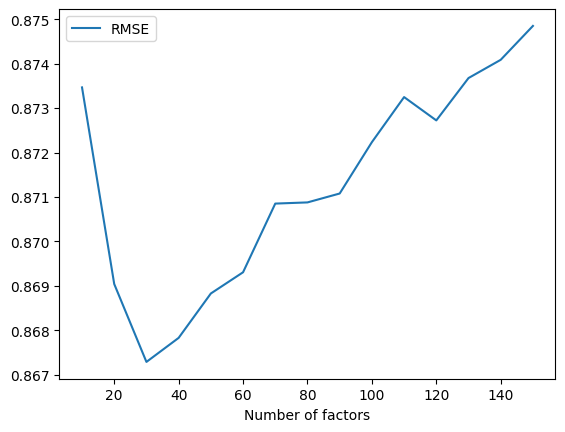

In [34]:
# number of epochs = 20, learning rate = 0.005
import matplotlib.pyplot as plt
# import pandas as pd

df = pd.DataFrame({"Number of factors": numOfFac_df,
                   "RMSE" : test_rmse_df_fac })
df.plot(x="Number of factors", y="RMSE")
plt.show()

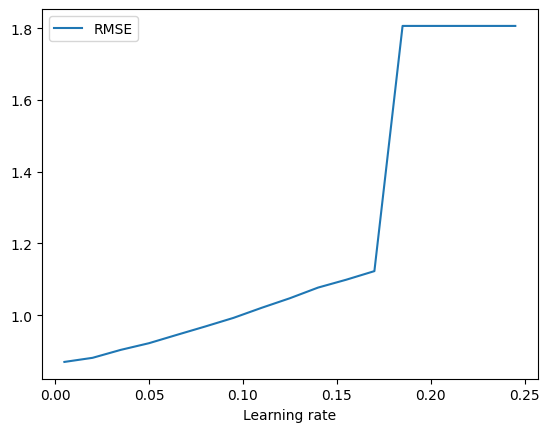

In [20]:
# number of epochs = 20, number of factors = 20
import matplotlib.pyplot as plt
# import pandas as pd

df = pd.DataFrame({"Learning rate": lr_rate_df,
                   "RMSE" : test_rmse_df_lr })
df.plot(x="Learning rate", y="RMSE")
plt.show()

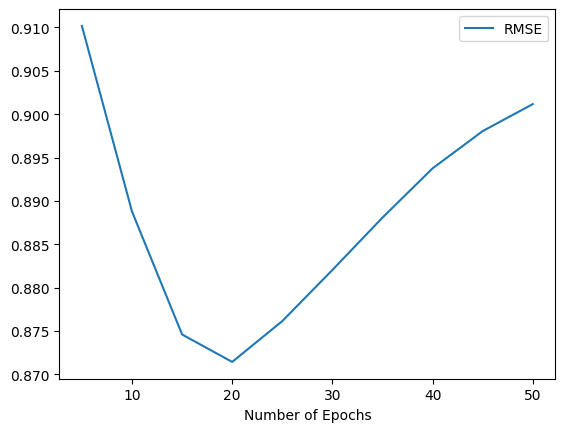

In [16]:
# learning rate = 0.005
import matplotlib.pyplot as plt
# import pandas as pd

df = pd.DataFrame({"Number of Epochs": num_epochs,
                   "RMSE" : test_rmse_df_epoch })
df.plot(x="Number of Epochs", y="RMSE")
plt.show()

In [14]:
# test_df = algo.test(testset)
# test = pd.DataFrame(test_df)
# test.drop("details", inplace=True, axis=1)
# test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
# test.head()

In [11]:
# test_k = test[["actual","cf_predictions"]].copy()
# test_k.head()

,actual,cf_predictions
0,3.0,3.267531
1,5.0,3.458290
2,3.5,3.979740
3,4.5,4.404299
4,2.0,1.599286


In [1]:
# test_k = test[["actual","cf_predictions"]].copy()
# test_k = test_k.rename(columns={"actual": "y_actual", "cf_predictions": "y_recommended"})
# print(test_k.head(10))
# print("test_k-1  shape :",test_k.shape)
# test_k.sort_values(by='y_recommended',ascending=False,inplace=True)
# # remove rows with missing values
# test_k.dropna(inplace=True)
# print("test_k-2  shape :",test_k.shape)
# # convert ratings to binary labels
# threshold = 3
# test_k = test_k >= threshold
# print("test_k-3  shape :",test_k.shape)
# # view results
# test_k.head(10)

NameError: ignored

In [25]:
# test_k.tail(10)

,y_actual,y_recommended
11732,True,False
22448,False,False
8768,False,False
11118,True,False
3120,False,False
19322,False,False
15834,False,False
21657,False,False
22598,False,False
1865,False,False


In [26]:
# def precision_at_k(df: pd.DataFrame, k: int=3, y_test: str='y_actual', y_pred: str='y_recommended') -> float:
#     """
#     Function to compute precision@k for an input boolean dataframe

#     Inputs:
#         df     -> pandas dataframe containing boolean columns y_test & y_pred
#         k      -> integer number of items to consider
#         y_test -> string name of column containing actual user input
#         y-pred -> string name of column containing recommendation output

#     Output:
#         Floating-point number of precision value for k items
#     """
#     # check we have a valid entry for k
#     if k <= 0:
#         raise ValueError('Value of k should be greater than 1, read in as: {}'.format(k))
#     # check y_test & y_pred columns are in df
#     if y_test not in df.columns:
#         raise ValueError('Input dataframe does not have a column named: {}'.format(y_test))
#     if y_pred not in df.columns:
#         raise ValueError('Input dataframe does not have a column named: {}'.format(y_pred))

#     # extract the k rows
#     dfK = df.head(k)
#     # compute number of recommended items @k
#     denominator = dfK[y_pred].sum()
#     # compute number of recommended items that are relevant @k
#     numerator = dfK[dfK[y_pred] & dfK[y_test]].shape[0]
#     # return result
#     if denominator > 0:
#         return numerator/denominator
#     else:
#         return None

# def recall_at_k(df: pd.DataFrame, k: int=3, y_test: str='y_actual', y_pred: str='y_recommended') -> float:
#     """
#     Function to compute recall@k for an input boolean dataframe

#     Inputs:
#         df     -> pandas dataframe containing boolean columns y_test & y_pred
#         k      -> integer number of items to consider
#         y_test -> string name of column containing actual user input
#         y-pred -> string name of column containing recommendation output

#     Output:
#         Floating-point number of recall value for k items
#     """
#     # check we have a valid entry for k
#     if k <= 0:
#         raise ValueError('Value of k should be greater than 1, read in as: {}'.format(k))
#     # check y_test & y_pred columns are in df
#     if y_test not in df.columns:
#         raise ValueError('Input dataframe does not have a column named: {}'.format(y_test))
#     if y_pred not in df.columns:
#         raise ValueError('Input dataframe does not have a column named: {}'.format(y_pred))

#     # extract the k rows
#     dfK = df.head(k)
#     # compute number of all relevant items
#     denominator = df[y_test].sum()
#     # compute number of recommended items that are relevant @k
#     numerator = dfK[dfK[y_pred] & dfK[y_test]].shape[0]
#     # return result
#     if denominator > 0:
#         return numerator/denominator
#     else:
#         return None

In [27]:
# k = 3
# print('Precision@k: {:.4f}, Recall@k: {:.4f} for k={}'.format(precision_at_k(test_k,k),recall_at_k(test_k,k),k))

Precision@k: 1.0000, Recall@k: 0.0001 for k=3


In [28]:
# k = 10
# print('Precision@k: {:.2f}, Recall@k: {:.2f} for k={}'.format(precision_at_k(test_k,k),recall_at_k(test_k,k),k))

Precision@k: 1.00, Recall@k: 0.00 for k=10


In [29]:
# k = 15
# print('Precision@k: {:.2f}, Recall@k: {:.2f} for k={}'.format(precision_at_k(test_k,k),recall_at_k(test_k,k),k))

Precision@k: 1.00, Recall@k: 0.00 for k=15


In [33]:
# k = 500
# print('Precision@k: {:.2f}, Recall@k: {:.2f} for k={}'.format(precision_at_k(test_k,k),recall_at_k(test_k,k),k))

Precision@k: 0.99, Recall@k: 0.02 for k=500


In [11]:
# print("MSE: ", recmetrics.mse(test.actual, test.cf_predictions))
# print("RMSE: ", recmetrics.rmse(test.actual, test.cf_predictions))

MSE:  0.7772288482960913
RMSE:  0.8816058349943535


In [12]:
# recmetrics.recommender_precision(test.actual, test.cf_predictions)

In [13]:
# # print("Precision@k: ", recmetrics.p@k(test.actual, test.cf_predictions))
# evaluate(algo, data, measures=['RMSE'])
# print("RMSE: ", recmetrics.rmse(test.actual, test.cf_predictions))
# cross_validate(algo, data, measures=['rmse', 'mae'], cv=2)

{'test_rmse': array([0.8905942 , 0.88870448]),
 'test_mae': array([0.68573316, 0.6841685 ]),
 'fit_time': (0.9936261177062988, 1.5312063694000244),
 'test_time': (0.5482451915740967, 0.5202157497406006)}

In [14]:
# train_df = algo.test(trainset)

TypeError: ignored

In [35]:
algo = SVD(n_epochs=20,n_factors=30)
# , n_factors=num_of_factors

algo.fit(trainset)
# algo.fit(data_train)


# Calculate RMSE for training dataset
# train_pred = algo.test(data_trainset)
# accuracy.rmse(train_pred)
# train_df = algo.test(trainset)
# trainDf = pd.DataFrame(train_df)
# trainDf.drop("details", inplace=True, axis=1)
# trainDf.columns = ['userId', 'movieId', 'actual', 'cf_predictions']

test_df = algo.test(testset)



# test_pred = algo.test(data_testset)
# accuracy.rmse(test_pred)


test = pd.DataFrame(test_df)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
accuracy.rmse(test_df)

RMSE: 0.8674


0.8673527210101232

In [36]:
accuracy.mae(test_df)

MAE:  0.6821


0.6820633752551103

In [23]:
# accuracy.rmse(test_df)

RMSE: 0.8694


0.8693736807348427

In [24]:
# accuracy.mae(test_df)

MAE:  0.6840


0.6840149157889376

In [37]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [38]:
# all_movies_df = pd.read_csv('/content/drive/My Drive/SWM/ml-20m/movies.csv')
# all_movies_df = pd.read_csv('/content/drive/My Drive/SWM/ml-latest-small/movies.csv')
all_movies_df = pd.read_csv(data_dir+"/movies.dat", sep='::', engine='python', encoding='latin1', header=0)

In [39]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)
    # recommended_items = recommended_items.head(n)
    movieid_list = recommended_items.index.tolist()
    user_data = ratings[ratings.userId == (user_id)]
    already_rated_user_full = (user_data.merge(all_movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').sort_values(['rating'], ascending=False))
    rated_list = list(already_rated_user_full["movieId"])
    res = [i for i in movieid_list if i not in rated_list]
    # recommended_items = recommended_items.head(n)
    movie_df = pd.DataFrame(res[:10], columns=['movieId'])
    final_list = movie_df.merge(all_movies_df, on='movieId', how='left')
    return final_list

In [40]:
userID = 590
user_data = ratings[ratings.userId == (userID)]
already_rated_user_full = (user_data.merge(all_movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').sort_values(['rating'], ascending=False))

In [41]:
already_rated_user_full

,userId,movieId,rating,timestamp,title,genres
137,590,36,5,975912908,Dead Man Walking (1995),Drama
112,590,308,5,975913075,Three Colors: White (1994),Drama
71,590,2318,5,975913197,Happiness (1998),Comedy
80,590,2502,5,975913485,Office Space (1999),Comedy|Romance
143,590,50,5,975912731,"Usual Suspects, The (1995)",Crime|Thriller
...,...,...,...,...,...,...
43,590,3618,2,975912393,Small Time Crooks (2000),Comedy
86,590,3324,2,975912061,Drowning Mona (2000),Comedy
64,590,3863,2,975912393,"Cell, The (2000)",Sci-Fi|Thriller
151,590,3752,2,975911852,"Me, Myself and Irene (2000)",Comedy


In [42]:
#get example prediction
recommended_pred = get_users_predictions(590, 10, cf_model)
recommended_pred

,movieId,title,genres
0,2514,Pet Sematary II (1992),Horror
1,2674,"Loss of Sexual Innocence, The (1999)",Drama
2,2675,Twice Upon a Yesterday (1998),Comedy|Drama|Romance
3,2672,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller
4,2671,Notting Hill (1999),Comedy|Romance
5,2670,"Run Silent, Run Deep (1958)",War
6,2526,Meteor (1979),Sci-Fi
7,2677,Buena Vista Social Club (1999),Documentary
8,2676,Instinct (1999),Drama|Thriller
9,2668,Swamp Thing (1982),Horror|Sci-Fi


In [27]:
list(recommended_pred["movieId"])

[2670, 2664, 2665, 2666, 2667, 2668, 2669, 2533, 2672, 2673]

In [28]:
for i in list(recommended_pred["movieId"]):
    if (i in list(already_rated_user_full["movieId"])):
        print("Already in list")

In [21]:
# model_probs = np.concatenate([np.random.normal(loc=.2, scale=0.5, size=500), np.random.normal(loc=.9, scale=0.5, size=500)])
# actual = [0] * 500
# class_zero_actual = [1] * 500
# actual.extend(class_zero_actual)

# recmetrics.roc_plot(actual, model_probs, model_names="one model",  figsize=(10, 5))

In [ ]:

# final_list